In [1]:
import torch
import torchvision.datasets as datasets
import torch.nn as nn
import torchvision.transforms as transforms

import torch.nn.functional as F
import numpy as np
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
INPUT_SHAPE = (784,)
pop_size = 10
generations = 5
# l = [784, 500, 250, 100, 50]
# l = [784, 500]
# init = glorot_uniform(seed = 12)
epochs_FineTune = 3

In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])
batch_size = 32
device = torch.device("cpu")
data_path = "../data"

In [3]:
train_dataset = datasets.MNIST(root=data_path, train= True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=data_path, train= False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size, shuffle=True)

5


60000

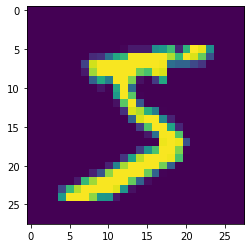

In [4]:
plt.imshow(  train_dataset[0][0].squeeze()  )
print(train_dataset[0][1])
len(train_dataset)

In [5]:
class TiedLinearLayer(nn.Module):
    def __init__(self, inp, out):
        super().__init__()
        self.param = nn.Parameter(torch.zeros(out, inp))
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.xavier_uniform_(self.param)

    def forward(self, input, transpose):
        if transpose is False:
            output = F.linear(input, self.param)
        else:
            output = F.linear(input, self.param.t())
        return output
    
class SingleTiedAutoEncoder(nn.Module):
    def __init__(self, inp, out):
        super().__init__()
        self.layers = TiedLinearLayer(inp,out)

    def forward(self, input):
        x = torch.flatten(input, start_dim=1) 
        x = self.layers(x, transpose = False) 
        x = self.layers(x, transpose = True)
        return x
    
class TiedAutoEncoder(nn.Module):
    def __init__(self, shape_list, nonlinearity=torch.relu):
        super().__init__()
        self.layers = nn.ModuleList([])
        self.nonlinearity = nonlinearity
        self.shape_list = shape_list   
        for i in range(len(self.shape_list)-1):
            self.layers.append(TiedLinearLayer(self.shape_list[i],self.shape_list[i+1]))

    def forward(self, input):
        x = torch.flatten(input, start_dim=1) 
        #encode
        for layer in self.layers:
            x = layer(x, transpose = False)
            x = self.nonlinearity(x)
        encoded_feats = x.detach().clone()
        #decode
        for i, layer in sorted( enumerate(self.layers), reverse=True ):
            x = layer(x, transpose = True)
            if i !=0: #if it's not the last layer
                x = self.nonlinearity(x)
        reconstructed_output = x
        return encoded_feats, reconstructed_output
    
def train(model, device, train_loader, optimizer, epoch, loss_fn=F.mse_loss):
    model.train()
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        encoded_feats, reconstructed_output  = model(data)
        target = torch.flatten(data, start_dim=1)
        loss = loss_fn(reconstructed_output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
@torch.no_grad()
def evaluate_loss(model, data_loader, device):
    val_loss = 0
    for data, _ in data_loader:
        data = data.to(device)
        _ , reconstructed_output  = model(data)
        target = torch.flatten(data, start_dim=1)
        loss = F.mse_loss(reconstructed_output, target)
        val_loss += loss

    validation_loss = val_loss/ len(data_loader)    
    return validation_loss

def layer_wise_train(model, device, train_loader, lr, epoch, loss_fn=F.mse_loss): 
#     shape_list = [784, 500, 250, 100, 50]
    shape_list = model.shape_list
    current_shape_list = []
    weight_state_dict = {}

    for layer_shape in shape_list:
        current_shape_list.append(layer_shape)
        if len(current_shape_list) < 2:
            continue  
        model = TiedAutoEncoder(current_shape_list, nonlinearity =torch.relu)
        print("training .... \n", model)
        #load prev weights 
        model.load_state_dict(weight_state_dict, strict=False)

        #freeze network except last layer
        for param in list(model.parameters())[:-1]:
            param.requires_grad = False
        #train the model
        optimizer = optim.Adadelta(model.parameters(), lr=lr)
        for epoch in range(1, epoch+1):
            train(model, device, train_loader, optimizer, epoch, loss_fn)
        #update weights
        weight_state_dict = model.state_dict()
        


In [54]:
#simple training
model = TiedAutoEncoder(shape_list = [784, 500, 250, 100, 50], nonlinearity =torch.relu)
model = TiedAutoEncoder(shape_list = [784, 500], nonlinearity =torch.relu)
optimizer = optim.Adadelta(model.parameters(), lr=lr)
for epoch in range(1, 5):
    train(model, device, train_loader, optimizer, epoch, loss_fn = F.mse_loss)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.095326
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.058892
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.052115
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.042417
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.040422
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.037493
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.038556
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.038791


In [101]:
#layer-wise training 
lr = 0.05
shape_list = [784, 500, 250, 100, 50]
model = TiedAutoEncoder(shape_list, nonlinearity =torch.relu)
layer_wise_train(model, device, train_loader, lr, epoch, loss_fn=F.mse_loss)    
torch.save(model.state_dict(), "./torchlogs/weihts_1.pth")

training .... 
 TiedAutoEncoder(
  (layers): ModuleList(
    (0): TiedLinearLayer()
  )
)
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.096132
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.045417
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.037139
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.034012
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.032741
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.026232
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.025182
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.020832
training .... 
 TiedAutoEncoder(
  (layers): ModuleList(
    (0): TiedLinearLayer()
    (1): TiedLinearLayer()
  )
)
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.084084
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.042688
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.033100
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.031166
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.026675
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.028338
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.024939
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.022440
training .... 
 TiedAutoEncoder(


In [39]:
class GeneticTiedAutoEncoder(TiedAutoEncoder):
    def __init__(self, shape_list, nonlinearity=torch.relu):
        super().__init__(shape_list, nonlinearity)
        
    @torch.no_grad()  
    def crossover(self, parent, layer_key, p):
        parent1 = self.state_dict()[layer_key]
        parent2 = parent.state_dict()[layer_key]
        assert parent1.shape == parent2.shape , "shape of parents should match"

        weights_mask = torch.FloatTensor(parent1.shape).uniform_(0, 1) <= p
        new_chromosome = parent1 * weights_mask + parent2 * weights_mask.logical_not()
        
        child = GeneticTiedAutoEncoder(self.shape_list, self.nonlinearity)
        child.state_dict()[layer_key] = weights_mask  
        return child
        
    @torch.no_grad()      
    def mutation(self, layer_key, p):
        chromosome = self.state_dict()[layer_key]
        weights_mask = torch.FloatTensor(chromosome.shape).uniform_(0, 1) > p 
        self.state_dict()[layer_key] = chromosome * weights_mask  
        
def train_genetic_model(shape_list, pop_size, generations, prev_weights = {}, finetune_epoch=3, finetune_lr=0.01 , loss_fn=F.mse_loss):    
    
    #Generate choromosomes
    print("\nGenerated {0} models with {1} layer size! ".format(pop_size, shape_list))
    models = [GeneticTiedAutoEncoder(shape_list, nonlinearity =torch.relu) for i in range(pop_size)]
   
    #Load prevoius layer weights
    print()
    if prev_weights != {}:
        for model in models:
             model.load_state_dict(prev_weights, strict=False)
        shapes = []
        for key_weight in prev_weights:
            shapes.append(prev_weights[key_weight].shape)
        print("\nLoaded prevoius layer weights with shape {0}".format(shapes))
    
    layer_key = next(reversed(models[0].state_dict())) #last layer key
    print("\nTraining {0} with shape of {1} : ".format(layer_key, models[0].state_dict()[layer_key].shape))
    
    for g in range(generations):     
        print("\nGeneration {0}: \n".format(g+1))
        print("Calculating fitness for each chromosome...")
        #fitness
        fitness = []
        for model in models:
            fitness.append( 1/evaluate_loss(model, train_loader, device))

        #Select 5 best models (/choromosomes)
        fit_arg = np.argsort(fitness) 
        selected_models = [models[f] for f in fit_arg[:pop_size//2]]
        print("Selected {0} Top best chromosomes".format(pop_size//2))
        

        #finetune selected models
        print("Finetuning selected models...\n")
        for model in selected_models:
            #freeze network except the chromosome layer
            for name, param in model.named_parameters():
                if name == layer_key:
                    param.requires_grad = True
                else:
                    param.requires_grad = False

            #train the model
            optimizer = optim.Adadelta(model.parameters(), lr=finetune_lr)
            for epoch in range(1, finetune_epoch+1):
                train(model, device, train_loader, optimizer, epoch, loss_fn)
            

        #cross over and mutation    
        print("Generate {0} other chromosomes with Cross-Over and Mutation\n".format( pop_size//2))
        for _ in range(pop_size//2):
            mom_idx = np.random.randint(low=0, high=pop_size//2)
            dad_idx = np.random.randint(low=0, high=pop_size//2)
            child = selected_models[mom_idx].crossover(selected_models[dad_idx],layer_key, p=0.8)
            child.mutation(layer_key, p=0.01)
            selected_models.append(child)
        models = selected_models
        
    fitness = []    
    print("Selecting best chromosome as answer...")
    #fitness
    for model in models:
        fitness.append( 1/evaluate_loss(model, train_loader, device))
    fit_arg = np.argsort(fitness) 
    best_model = models[fit_arg[-1]]
    print("Finished")
    return best_model
    
            

In [46]:
shape_list = [784, 500, 200, 100]
shape_list = [784, 500]
pop_size = 10 
generations = 2
finetune_epoch = 0
finetune_lr = 0.01
prev_weights = {}

model = train_genetic_model(shape_list, pop_size, generations, prev_weights, finetune_epoch, finetune_lr)


Generated 10 models with [784, 500] layer size! 


Training layers.0.param with shape of torch.Size([500, 784]) : 

Generation 1: 

Calculating fitness for each chromosome...
Selected 5 Top best chromosomes
Finetuning selected models...

Generate 5 other chromosomes with Cross-Over and Mutation


Generation 2: 

Calculating fitness for each chromosome...
Selected 5 Top best chromosomes
Finetuning selected models...

Generate 5 other chromosomes with Cross-Over and Mutation

Selecting best chromosome as answer...


In [9]:
def layerwise_genetic_train(shape_list, pop_size, generations, finetune_epoch=3, finetune_lr=0.01 , loss_fn=F.mse_loss):    
    current_shape_list = []
    weight_state_dict = {}

    for layer_shape in shape_list:
        current_shape_list.append(layer_shape)
        if len(current_shape_list) < 2:
            continue  
        model = train_genetic_model(current_shape_list, pop_size, generations, weight_state_dict, finetune_epoch, finetune_lr , loss_fn)
        weight_state_dict = model.state_dict()
    return model
    

In [40]:
shape_list = [784, 20, 10 , 5 , 1]
pop_size = 10 
generations = 2
finetune_epoch = 0
finetune_lr = 0.01

model = layerwise_genetic_train(shape_list, pop_size, generations, finetune_epoch, finetune_lr)


Generated 10 models with [784, 20] layer size! 


Training layers.0.param with shape of torch.Size([20, 784]) : 

Generation 1: 

Calculating fitness for each chromosome...
Selected 5 Top best chromosomes
Finetuning selected models...

Generate 5 other chromosomes with Cross-Over and Mutation


Generation 2: 

Calculating fitness for each chromosome...
Selected 5 Top best chromosomes
Finetuning selected models...

Generate 5 other chromosomes with Cross-Over and Mutation

Selecting best chromosome as answer...
Finished

Generated 10 models with [784, 20, 10] layer size! 


Loaded prevoius layer weights with shape [torch.Size([20, 784])]

Training layers.1.param with shape of torch.Size([10, 20]) : 

Generation 1: 

Calculating fitness for each chromosome...
Selected 5 Top best chromosomes
Finetuning selected models...

Generate 5 other chromosomes with Cross-Over and Mutation


Generation 2: 

Calculating fitness for each chromosome...
Selected 5 Top best chromosomes
Finetuning select

In [41]:
model

GeneticTiedAutoEncoder(
  (layers): ModuleList(
    (0): TiedLinearLayer()
    (1): TiedLinearLayer()
    (2): TiedLinearLayer()
    (3): TiedLinearLayer()
  )
)

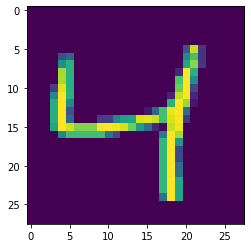

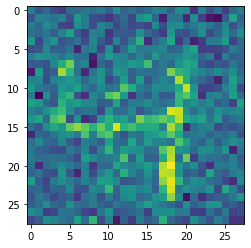

In [42]:
data_sample = train_dataset[2][0]
plt.imshow(data_sample.squeeze())
plt.show()
encoded_feats, reconstructed_output = model(data_sample)
# reconstructed_output = model(data_sample)
plt.imshow(reconstructed_output.detach().numpy().reshape(28,28) )
plt.show()